# September 10th, 2018
## Benjamin Adam Catching
## Polio-virus DIPs Project
## Andino Lab

New brightfield cells have been sent by Christian from the Abate lab. The 10X image will be analyzed first for both the droplets and the cells contained. The goal is to have an array of droplets that can be used to modify and adjust the cell segmentation algorithm. If the current algorithm cannot be pushed to detect > 3 cells per droplet, machine learning methods may be required and experimented on the segmented droplets.

In [1]:
# Import packages
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
import scipy
import pandas as pd
import os
import sys
from PIL import Image
# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
# Define the location of the files
bulk_cell_dir_10x = '../../data/20180907_10x Objective_Autoscan_EVOS_BF/*.tif'
bulk_cell_dir_20x = '../../data/20180907_20x Objective_Autoscan_EVOS_BF/*.tif'

# Get list of image files
all_raw_files_10x = sorted(glob.glob(bulk_cell_dir_10x))
all_raw_files_20x = sorted(glob.glob(bulk_cell_dir_20x))

In [3]:
# Import the processing script
import microfluidics_analysis as ma

In [4]:
# Get the whole-field stiched image
whole_field_10x_file = '../../data/20180907_10x Objective_Autoscan_EVOS_BF/Area1.png'
whole_field_20x_file = '../../data/20180907_20x Objective_Autoscan_EVOS_BF/Area1.png'
# Open with skimage
whole_field_10x_image = skimage.io.imread(whole_field_10x_file)
whole_field_20x_image = skimage.io.imread(whole_field_20x_file)

# Pixel to micron conversion
pix_to_mic_10x = 0.898722
pix_to_mic_20x = 0.451483

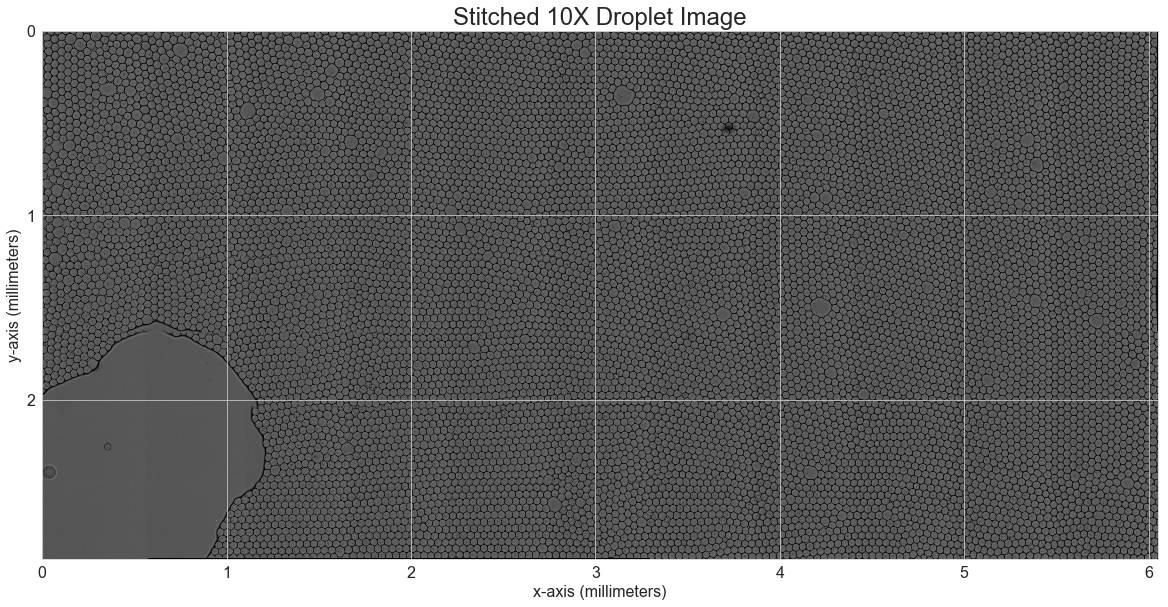

In [5]:

# Show the whole field image for 10x
y_axis_len, x_axis_len, z = whole_field_10x_image.shape

# Convert x axis to millimeters
x_axis_mill = int(x_axis_len / (1000*pix_to_mic_10x)) # Number of x-axis millimeters
x_axis_pix = np.linspace(0, (x_axis_mill)*1000*pix_to_mic_10x , x_axis_mill+1)
x_axis_mic = [int(x) for x in range(len(x_axis_pix)+1)]

# Convert y axis to millimeters
y_axis_mill = int(y_axis_len / (1000*pix_to_mic_10x))
y_axis_pix = np.linspace(0, y_axis_mill*1000*pix_to_mic_10x, y_axis_mill+1)
y_axis_mic = [int(x) for x in range(len(y_axis_pix)+1)]

# Plot the image
with sns.axes_style('whitegrid'):
    _ = plt.figure(figsize=(20, 10))
    _ = plt.imshow(whole_field_10x_image)
    _ = plt.title('Stitched 10X Droplet Image', size=24)
    _ = plt.xticks(x_axis_pix, x_axis_mic, size=16)
    _ = plt.xlabel('x-axis (millimeters)', size=16)
    _ = plt.yticks(y_axis_pix, y_axis_mic, size=16)
    _ = plt.ylabel('y-axis (millimeters)', size=16)
    plt.show()

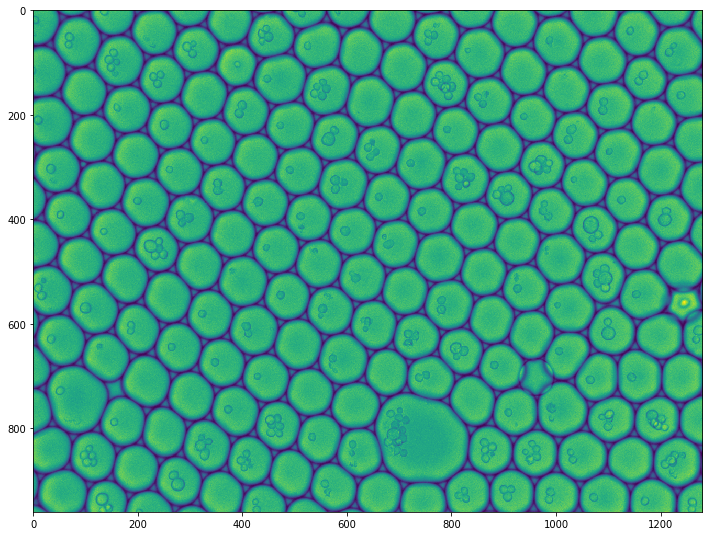

In [6]:
# Look at a single 10X image
temp_10x_img = skimage.io.imread(all_raw_files_10x[10])
_ = plt.figure(figsize=(10, 10))
_ = plt.imshow(temp_10x_img)
_ = plt.tight_layout()
plt.show()

In [7]:
# Get droplets from the single image
droplet_subset = ma.get_10x_droplets(all_raw_files_10x[10], brightfield=True)

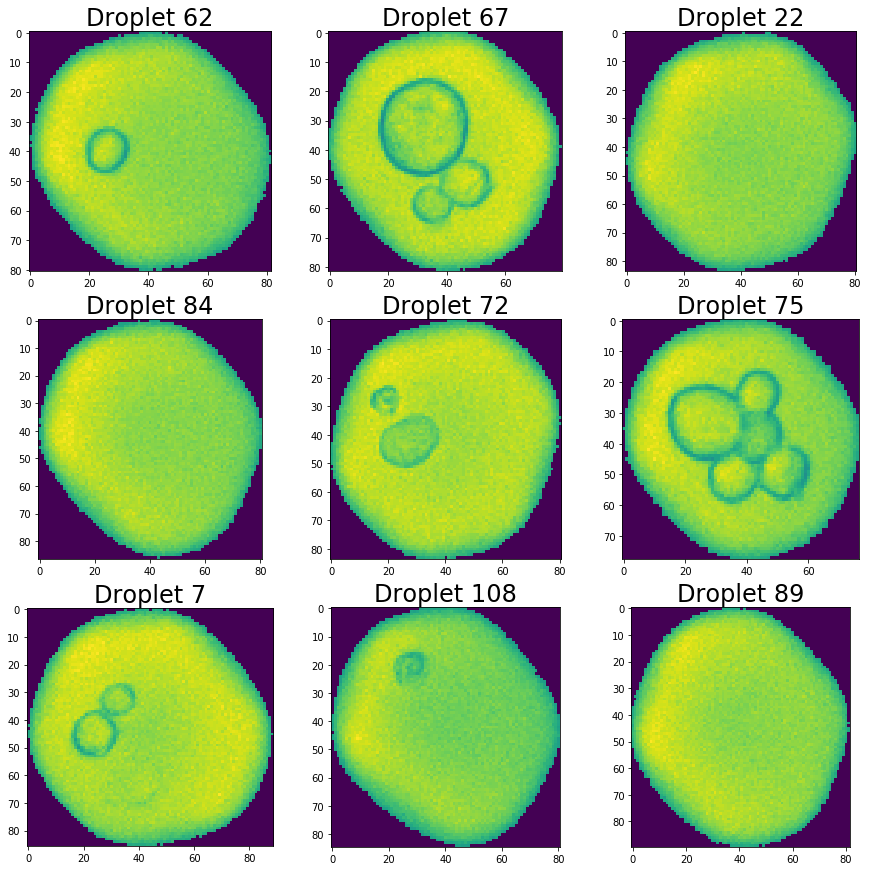

In [268]:
# Look at a couple of the droplets
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
rand_nums = np.random.randint(len(droplet_subset), size=(3, 3))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(droplet_subset[rand_nums[i, j]])
        ax[i, j].set_title(f'Droplet {rand_nums[i, j]}', size=24)
plt.show()

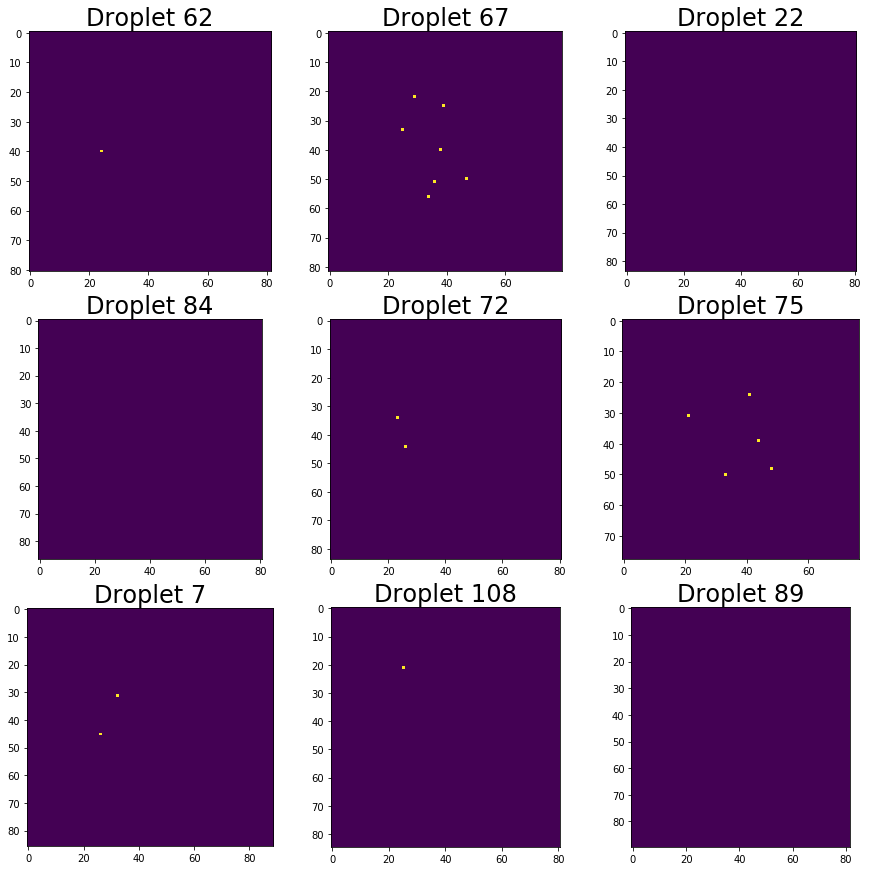

In [286]:
# Apply the Canny filter on the images
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
temp_seg_cells = []
for i in range(3):
    for j in range(3):
        temp_drop = droplet_subset[rand_nums[i, j]]
        temp_can = skimage.feature.canny(temp_drop, sigma=0.1)
        temp_close = scipy.ndimage.binary_closing(temp_can, iterations=2)
        seg_drop = scipy.ndimage.binary_fill_holes(temp_close)
        # Remove small areas
        cell_labels = skimage.measure.label(seg_drop)
        cell_props = skimage.measure.regionprops(cell_labels)
        
        # Initialize blank array
        cell_droplet = np.zeros(temp_drop.shape)

        for index, prop in enumerate(cell_props):
            #print(prop.area)
            # If the region properties are within the threshold
            if prop.area >= 78 and prop.eccentricity <= 0.90:
                # Select the region
                temp_seg = cell_labels==index+1
                filled_seg = temp_seg
                # Add to the blank image
                cell_droplet = cell_droplet + filled_seg
        
        # There now is a segmented region of the droplet called cell_droplet
        
        # Now find the center of each cell as a seed to find 
        seg_cells = temp_drop*cell_droplet
        gradient = skimage.filters.sobel(seg_cells, mask=cell_droplet)
        blur_grad = skimage.filters.gaussian(seg_cells)
        grad = skimage.filters.sobel(blur_grad, mask=cell_droplet)
        temp_seg_cells.append(blur_grad)
        
        distance = scipy.ndimage.distance_transform_edt(blur_grad)
        local_maxi = skimage.feature.peak_local_max(blur_grad, 
                                                    indices=False, 
                                                    footprint=skimage.morphology.square(10), 
                                                    labels=cell_droplet)
        markers = skimage.measure.label(local_maxi)
        #markers[~cell_droplet] = -1
        #segment = skimage.segmentation.random_walker(cell_droplet, markers)
        #loc_min = local_max(seg_cells, size=10)
        ax[i, j].imshow(local_maxi)
        ax[i, j].set_title(f'Droplet {rand_nums[i, j]}', size=24)
plt.show()

There obviously are some issues with segmenting this way. The algorithm should be able to deal with more than two cells in a droplet if any useful dynamics are going to be extracted with this data. 

The paper **Accurate cell segmentatino in microscopy images using membrane patterns** by _Dimopoulos et. al_ is what cell identification will be based off of.

In [28]:
# Create an array of images
canny_drops = np.array([skimage.feature.canny(x) for x in droplet_subset])

In [32]:
# Create an array of sub-images of a droplet
temp_drop_1 = droplet_subset[61]
temp_drop_2 = droplet_subset[134]

In [40]:
temp_drop_1_subimages = []
y_len, x_len = temp_drop_1.shape
for i in range(10, 30):
    for j in range(10, 30):
        for x in range(x_len-i):
            for y in range(y_len-j):
                new_pic = temp_drop_1[j:y, i:x]
                temp_drop_1_subimages.append(new_pic)

In [41]:
temp_drop_1_subimages
sub_rand_num = np.random.randint(temp_drop_1_subimages, size=(3, 3))
fig, 

1537500

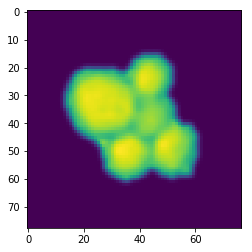

In [223]:
plt.imshow(temp_seg_cells[6])
plt.show()

In [291]:
multi_cell_seg = temp_seg_cells[6]
flat_multi_cell = multi_cell_seg.flatten()
non_zero_flat = flat_multi_cell * np.array([flat_multi_cell != 0])
plt.hist(non_zero_flat)
plt.show()

KeyboardInterrupt: 

In [212]:
def local_max(image, size=10):
    new_image = np.zeros(image.shape)
    y_len, x_len = grad.shape
    for i in range(x_len - size):
        for j in range(y_len - size):
            #print(i, j)
            temp_array = image[j:j+size, i:i+size]
            #print(temp_array)
            test_point = temp_array[1, 1]
            all_points = temp_array.flatten()
            for point in all_points:
                #print(all_points)
                if 0 not in all_points:
                    #print(point)
                    if test_point < point:
                        break
                    else:
                        #print(i, j)
                        new_image[j, i] = 1
    return new_image

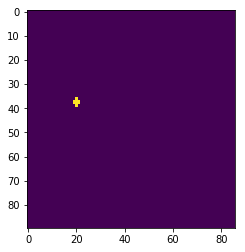

In [192]:
plt.imshow(new_image)
plt.show()

In [292]:
non_zero_flat

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])